## Soumil Nitin Shah 
Bachelor in Electronic Engineering |
Masters in Electrical Engineering | 
Master in Computer Engineering |

* Website : http://soumilshah.com/
* Github: https://github.com/soumilshah1995
* Linkedin: https://www.linkedin.com/in/shah-soumil/
* Blog: https://soumilshah1995.blogspot.com/
* Youtube : https://www.youtube.com/channel/UC_eOodxvwS_H7x2uLQa-svw?view_as=subscriber
* Facebook Page : https://www.facebook.com/soumilshah1995/
* Email : shahsoumil519@gmail.com
* projects : https://soumilshah.herokuapp.com/project

* I earned a Bachelor of Science in Electronic Engineering and a double master’s in Electrical and Computer Engineering. I have extensive expertise in developing scalable and high-performance software applications in Python. I have a YouTube channel where I teach people about Data Science, Machine learning, Elastic search, and AWS. I work as data Team Lead at Jobtarget where I spent most of my time developing Ingestion Framework and creating microservices and scalable architecture on AWS. I have worked with a massive amount of data which includes creating data lakes (1.2T) optimizing data lakes query by creating a partition and using the right file format and compression. I have also developed and worked on a streaming application for ingesting real-time streams data via kinesis and firehose to elastic search

# Learn About HUDI Cleaners

Hoodie Cleaner is a utility that helps you reclaim space and keep your storage costs in check. Apache Hudi provides snapshot isolation between writers and readers by managing multiple files with MVCC concurrency. These file versions provide history and enable time travel and rollbacks, but it is important to manage how much history you keep to balance your costs.

Automatic Hudi cleaning is enabled by default. Cleaning is invoked immediately after each commit, to delete older file slices. It's recommended to leave this enabled to ensure metadata and data storage growth is bounded.


##### KEEP_LATEST_COMMITS:
* This is the default policy. This is a temporal cleaning policy that ensures the effect of having lookback into all the changes that happened in the last X commits. Suppose a writer is ingesting data into a Hudi dataset every 30 minutes and the longest running query can take 5 hours to finish, then the user should retain atleast the last 10 commits. With such a configuration, we ensure that the oldest version of a file is kept on disk for at least 5 hours, thereby preventing the longest running query from failing at any point in time. Incremental cleaning is also possible using this policy. Number of commits to retain can be configured by hoodie.cleaner.commits.retained.

#####  KEEP_LATEST_FILE_VERSIONS: 
* This policy has the effect of keeping N number of file versions irrespective of time. This policy is useful when it is known how many MAX versions of the file does one want to keep at any given time. To achieve the same behaviour as before of preventing long running queries from failing, one should do their calculations based on data patterns. Alternatively, this policy is also useful if a user just wants to maintain 1 latest version of the file. Number of file versions to retain can be configured by hoodie.cleaner.fileversions.retained.

#### KEEP_LATEST_BY_HOURS: 
* This policy clean up based on hours.It is simple and useful when knowing that you want to keep files at any given time. Corresponding to commits with commit times older than the configured number of hours to be retained are cleaned. Currently you can configure by parameter hoodie.cleaner.hours.retained.

## Step 1: 
##### Define Imports 

In [131]:
try:

    import os
    import sys
    import uuid

    import pyspark
    from pyspark.sql import SparkSession
    from pyspark import SparkConf, SparkContext
    from pyspark.sql.functions import col, asc, desc
    from pyspark.sql.functions import col, to_timestamp, monotonically_increasing_id, to_date, when
    from pyspark.sql.functions import *
    from pyspark.sql.types import *
    from datetime import datetime
    from functools import reduce
    from faker import Faker


except Exception as e:
    pass

# Step 2:
#### Create Spark Instance 

In [132]:
SUBMIT_ARGS = "--packages org.apache.hudi:hudi-spark3.3-bundle_2.12:0.12.1 pyspark-shell"
os.environ["PYSPARK_SUBMIT_ARGS"] = SUBMIT_ARGS
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

spark = SparkSession.builder \
    .config('spark.serializer', 'org.apache.spark.serializer.KryoSerializer') \
    .config('spark.sql.extensions', 'org.apache.spark.sql.hudi.HoodieSparkSessionExtension') \
    .config('className', 'org.apache.hudi') \
    .config('spark.sql.hive.convertMetastoreParquet', 'false') \
    .getOrCreate()

In [133]:
spark

# Step 3: 
#### Definje Hudi Settings for this project 

In [141]:
db_name = "hudidb"
table_name = "hudi_table"

recordkey = 'uuid'
precombine = 'precomb'

path = f"file:///C:/tmp/{db_name}/{table_name}"
method = 'upsert'
table_type = "COPY_ON_WRITE"  # COPY_ON_WRITE | MERGE_ON_READ

hudi_options = {
    'hoodie.table.name': table_name,
    'hoodie.datasource.write.recordkey.field': recordkey,
    'hoodie.datasource.write.table.name': table_name,
    'hoodie.datasource.write.operation': method,
    'hoodie.datasource.write.precombine.field': precombine,
    'hoodie.upsert.shuffle.parallelism': 2,
    'hoodie.insert.shuffle.parallelism': 2
}

# Append Data 1

In [142]:
data_items = [
    (1, "This is APPEND 1",  111,"1"),
    (2, "This is APPEND 2",  222, "2"),
    
]

columns = ["uuid", "message", "precomb", "partition"]
spark_df = spark.createDataFrame(data=data_items, schema=columns)

spark_df.write.format("hudi"). \
    options(**hudi_options). \
    mode("append"). \
    save(path)

df = spark. \
      read. \
      format("hudi"). \
      load(path)

df.select(["_hoodie_file_name","partition"]).show(truncate=False)

+----------------------------------------------------------------------------+---------+
|_hoodie_file_name                                                           |partition|
+----------------------------------------------------------------------------+---------+
|0ca2d109-a683-4cc4-88ae-4d7ebb2e38e1-0_0-1521-2013_20230108190933156.parquet|1        |
|0ca2d109-a683-4cc4-88ae-4d7ebb2e38e1-0_0-1521-2013_20230108190933156.parquet|2        |
+----------------------------------------------------------------------------+---------+



# Appending Data 2

In [143]:
data_items = [
    (3, "This is APPEND ",  333,"2"),
    (4, "This is APPEND ",  444, "3"),

]

columns = ["uuid", "message", "precomb", "partition"]
spark_df = spark.createDataFrame(data=data_items, schema=columns)

spark_df.write.format("hudi"). \
    options(**hudi_options). \
    mode("append"). \
    save(path)

df = spark. \
      read. \
      format("hudi"). \
      load(path)

df.select(["_hoodie_file_name","partition"]).show(truncate=False)


+----------------------------------------------------------------------------+---------+
|_hoodie_file_name                                                           |partition|
+----------------------------------------------------------------------------+---------+
|0ca2d109-a683-4cc4-88ae-4d7ebb2e38e1-0_0-1555-2059_20230108191014916.parquet|1        |
|0ca2d109-a683-4cc4-88ae-4d7ebb2e38e1-0_0-1555-2059_20230108191014916.parquet|2        |
|0ca2d109-a683-4cc4-88ae-4d7ebb2e38e1-0_0-1555-2059_20230108191014916.parquet|2        |
|0ca2d109-a683-4cc4-88ae-4d7ebb2e38e1-0_0-1555-2059_20230108191014916.parquet|3        |
+----------------------------------------------------------------------------+---------+



# Append 3 

In [144]:
data_items = [
    (4, "This is APPEND ",  444,"4"),
    (5, "This is APPEND ",  555, "2")

    
]

columns = ["uuid", "message", "precomb", "partition"]
spark_df = spark.createDataFrame(data=data_items, schema=columns)

spark_df.write.format("hudi"). \
    options(**hudi_options). \
    mode("append"). \
    save(path)

df = spark. \
      read. \
      format("hudi"). \
      load(path)

df.select(["_hoodie_file_name","partition"]).show(truncate=False)


+----------------------------------------------------------------------------+---------+
|_hoodie_file_name                                                           |partition|
+----------------------------------------------------------------------------+---------+
|0ca2d109-a683-4cc4-88ae-4d7ebb2e38e1-0_0-1589-2105_20230108191029794.parquet|1        |
|0ca2d109-a683-4cc4-88ae-4d7ebb2e38e1-0_0-1589-2105_20230108191029794.parquet|2        |
|0ca2d109-a683-4cc4-88ae-4d7ebb2e38e1-0_0-1589-2105_20230108191029794.parquet|2        |
|0ca2d109-a683-4cc4-88ae-4d7ebb2e38e1-0_0-1589-2105_20230108191029794.parquet|4        |
|0ca2d109-a683-4cc4-88ae-4d7ebb2e38e1-0_0-1589-2105_20230108191029794.parquet|2        |
+----------------------------------------------------------------------------+---------+



# Append 4

In [145]:
data_items = [
    (6, "This is APPEND ",  666,"3"),
    (7, "This is APPEND ",  777, "1")
]

columns = ["uuid", "message", "precomb", "partition"]
spark_df = spark.createDataFrame(data=data_items, schema=columns)

spark_df.write.format("hudi"). \
    options(**hudi_options). \
    mode("append"). \
    save(path)

df = spark. \
      read. \
      format("hudi"). \
      load(path)

df.select(["_hoodie_file_name","partition"]).show(truncate=False)


+----------------------------------------------------------------------------+---------+
|_hoodie_file_name                                                           |partition|
+----------------------------------------------------------------------------+---------+
|0ca2d109-a683-4cc4-88ae-4d7ebb2e38e1-0_0-1626-2155_20230108191044633.parquet|1        |
|0ca2d109-a683-4cc4-88ae-4d7ebb2e38e1-0_0-1626-2155_20230108191044633.parquet|2        |
|0ca2d109-a683-4cc4-88ae-4d7ebb2e38e1-0_0-1626-2155_20230108191044633.parquet|2        |
|0ca2d109-a683-4cc4-88ae-4d7ebb2e38e1-0_0-1626-2155_20230108191044633.parquet|4        |
|0ca2d109-a683-4cc4-88ae-4d7ebb2e38e1-0_0-1626-2155_20230108191044633.parquet|2        |
|0ca2d109-a683-4cc4-88ae-4d7ebb2e38e1-0_0-1626-2155_20230108191044633.parquet|3        |
|0ca2d109-a683-4cc4-88ae-4d7ebb2e38e1-0_0-1626-2155_20230108191044633.parquet|1        |
+----------------------------------------------------------------------------+---------+



# I Have Close to 4 Files in my Data lake 

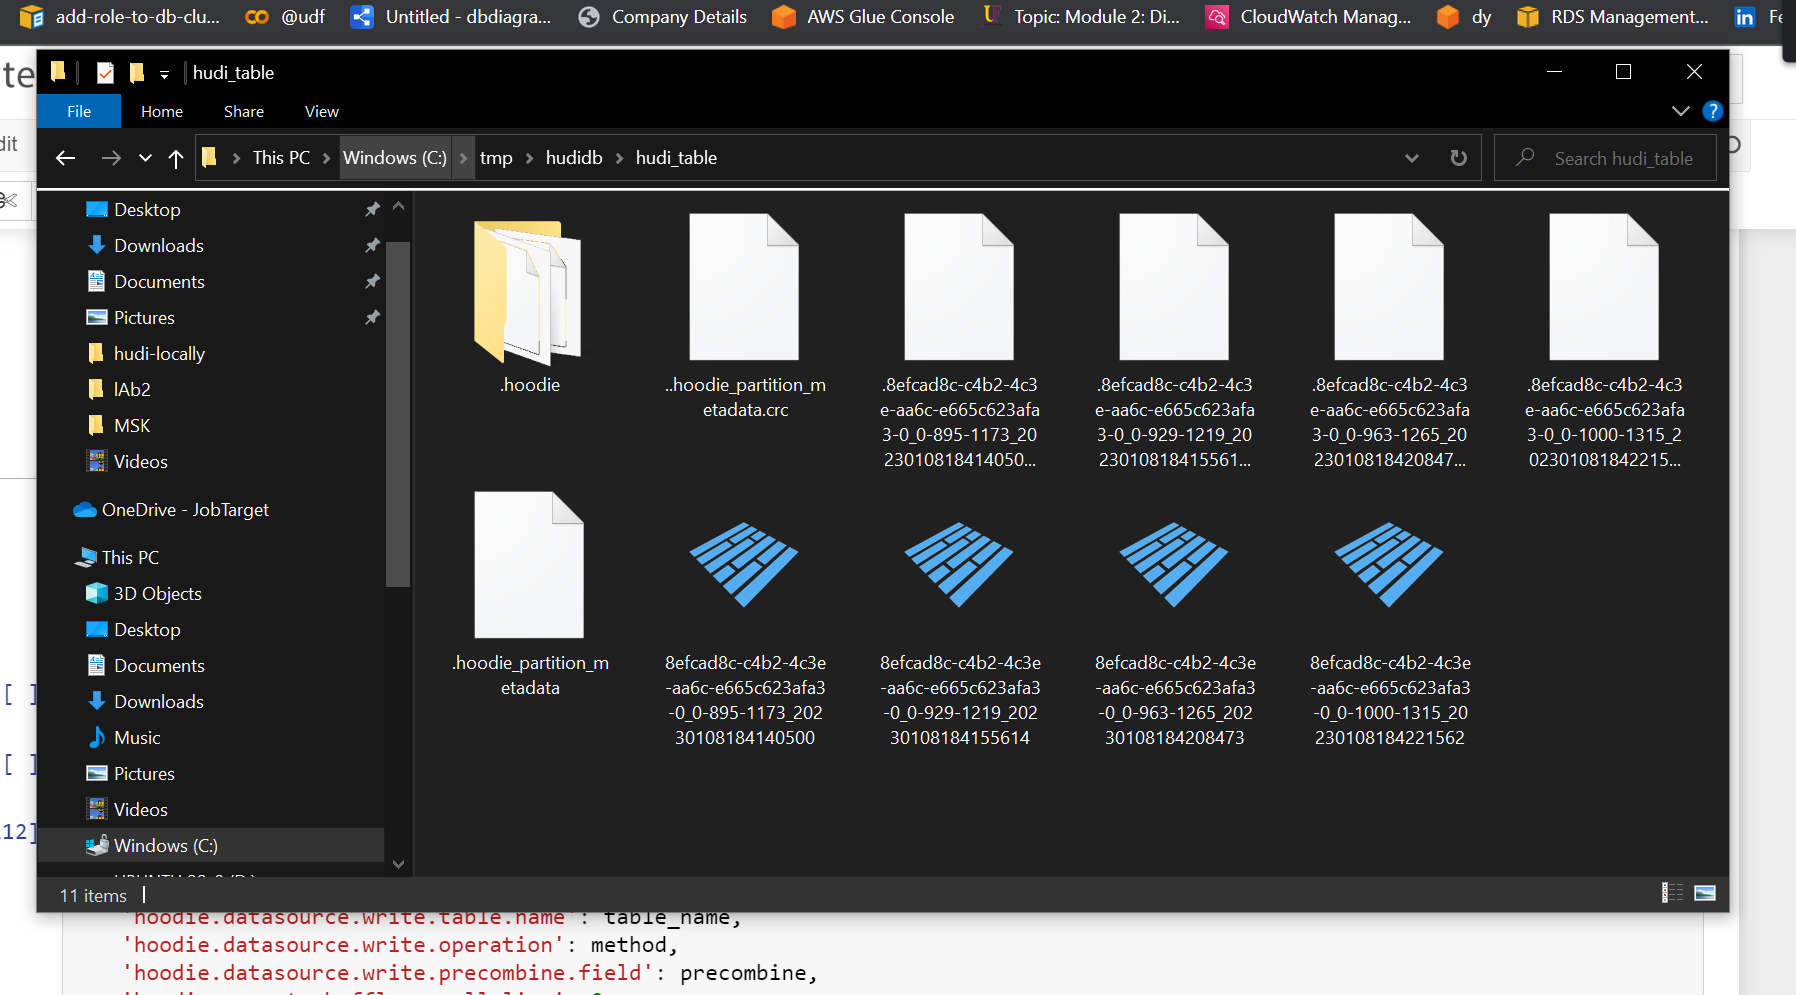

# Let me Enable Cleaner 

In [146]:
hudi_options = {
    'hoodie.table.name': table_name,
    'hoodie.datasource.write.recordkey.field': recordkey,
    'hoodie.datasource.write.table.name': table_name,
    'hoodie.datasource.write.operation': method,
    'hoodie.datasource.write.precombine.field': precombine,
    'hoodie.upsert.shuffle.parallelism': 2,
    'hoodie.insert.shuffle.parallelism': 2,
    
    "hoodie.clean.automatic":"true",
    "hoodie.clean.async":"true",
    "hoodie.cleaner.policy": 'KEEP_LATEST_FILE_VERSIONS',
    "hoodie.cleaner.fileversions.retained":"1"
    
}

In [147]:
data_items = [
    (8, "This is APPEND ",  888,"3"),
    (9, "This is APPEND ",  999, "1")
]

columns = ["uuid", "message", "precomb", "partition"]
spark_df = spark.createDataFrame(data=data_items, schema=columns)

spark_df.write.format("hudi"). \
    options(**hudi_options). \
    mode("append"). \
    save(path)

df = spark. \
      read. \
      format("hudi"). \
      load(path)

df.select(["_hoodie_file_name","partition"]).show(truncate=False)


+----------------------------------------------------------------------------+---------+
|_hoodie_file_name                                                           |partition|
+----------------------------------------------------------------------------+---------+
|0ca2d109-a683-4cc4-88ae-4d7ebb2e38e1-0_0-1668-2215_20230108191212280.parquet|1        |
|0ca2d109-a683-4cc4-88ae-4d7ebb2e38e1-0_0-1668-2215_20230108191212280.parquet|2        |
|0ca2d109-a683-4cc4-88ae-4d7ebb2e38e1-0_0-1668-2215_20230108191212280.parquet|2        |
|0ca2d109-a683-4cc4-88ae-4d7ebb2e38e1-0_0-1668-2215_20230108191212280.parquet|4        |
|0ca2d109-a683-4cc4-88ae-4d7ebb2e38e1-0_0-1668-2215_20230108191212280.parquet|2        |
|0ca2d109-a683-4cc4-88ae-4d7ebb2e38e1-0_0-1668-2215_20230108191212280.parquet|3        |
|0ca2d109-a683-4cc4-88ae-4d7ebb2e38e1-0_0-1668-2215_20230108191212280.parquet|1        |
|0ca2d109-a683-4cc4-88ae-4d7ebb2e38e1-0_0-1668-2215_20230108191212280.parquet|3        |
|0ca2d109-a683-4cc4-8

# Results

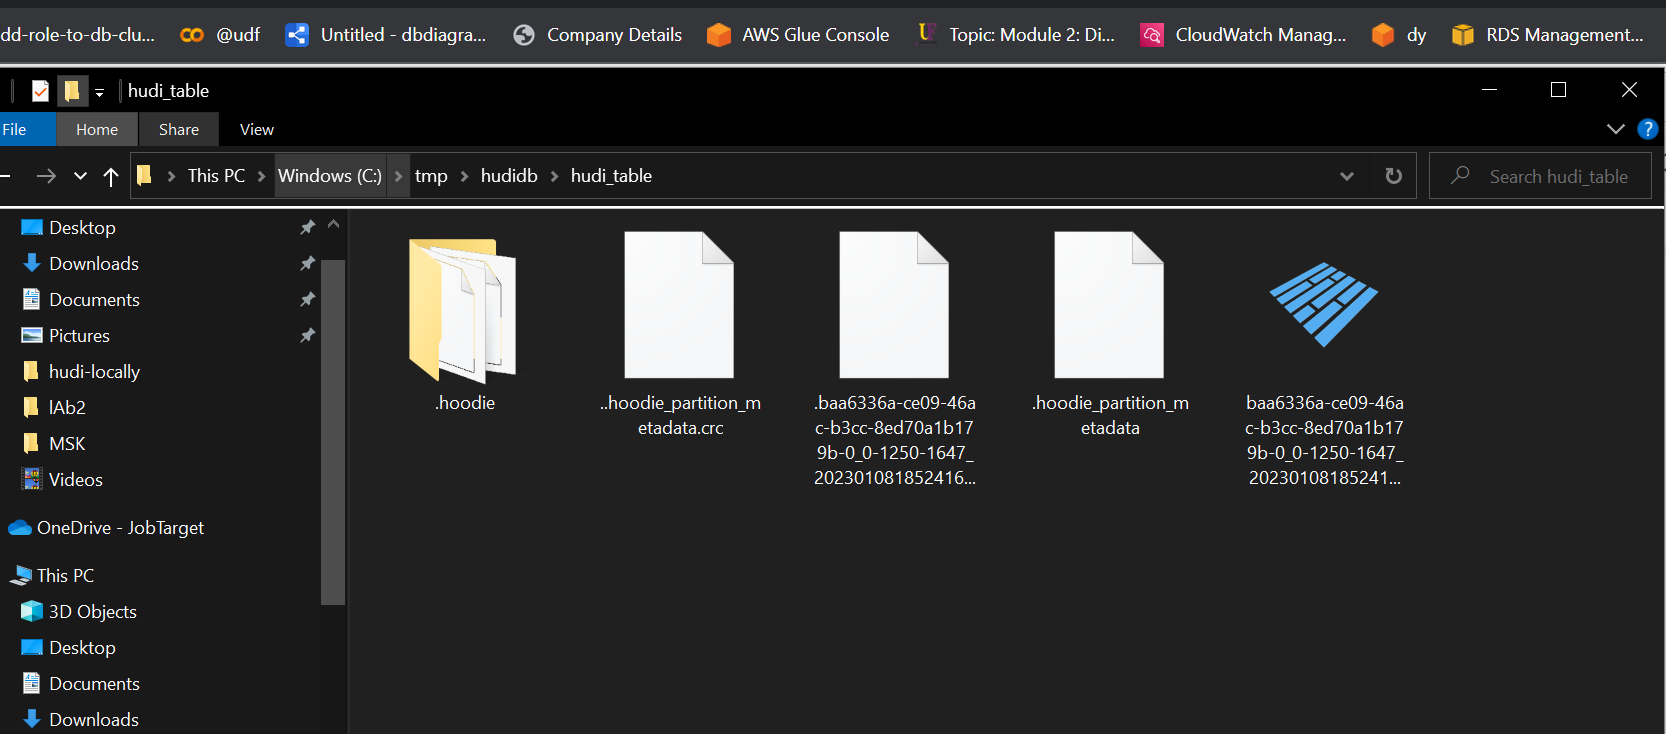

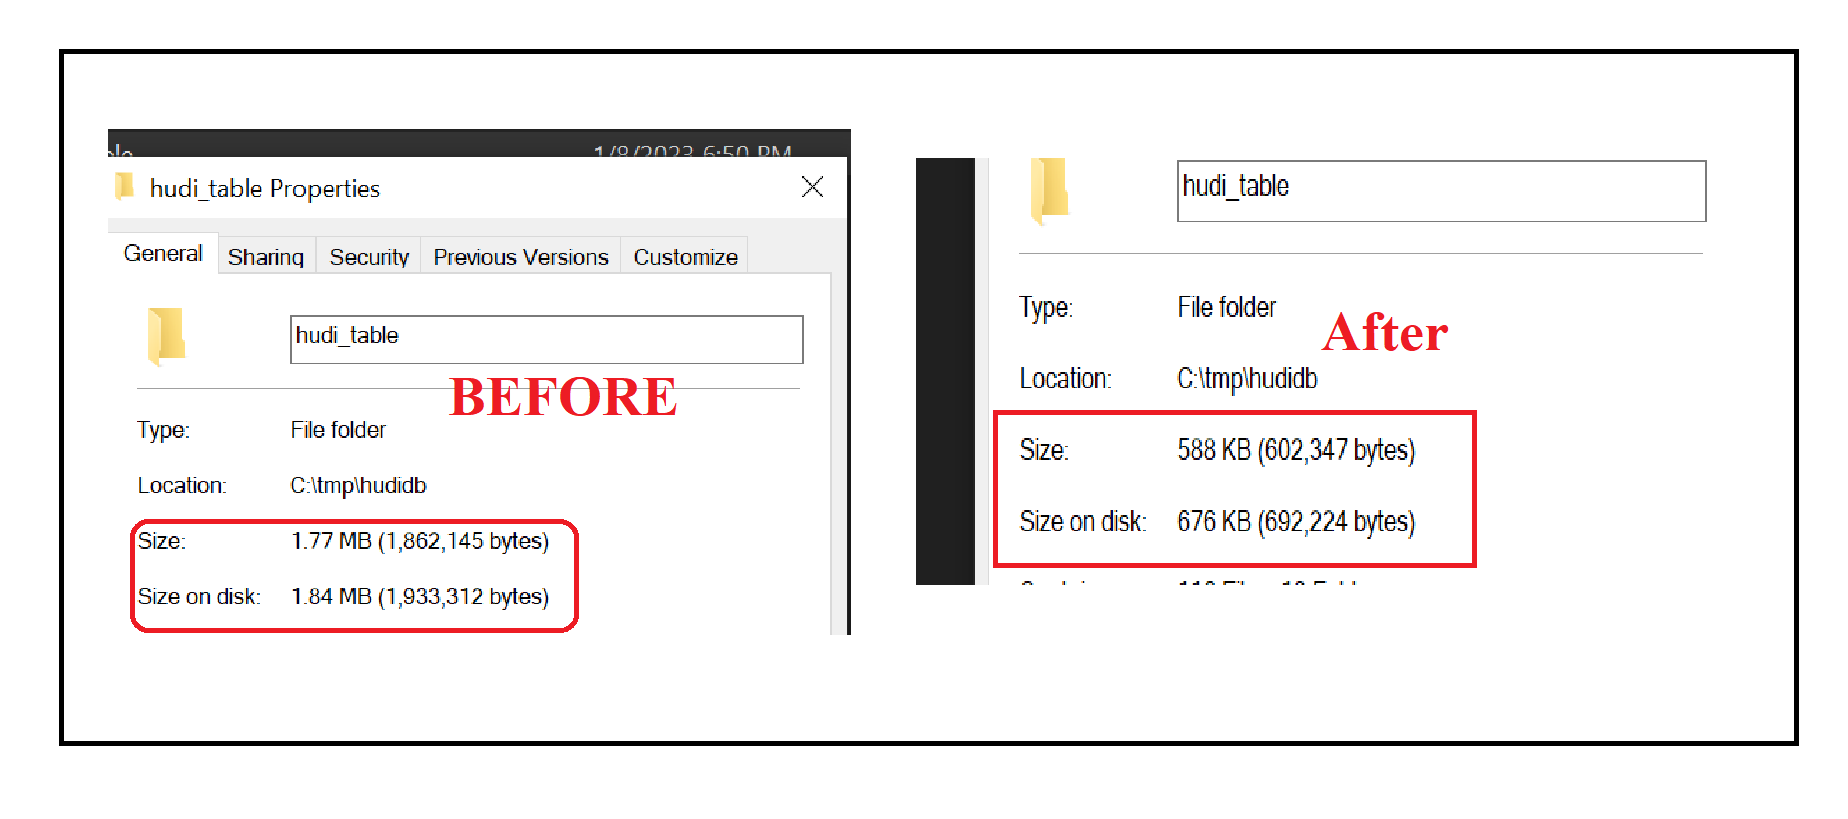